# Qubit Tune-up with SHF Instruments

In this notebook we demonstrate qubit tuneup with the LabOne Q software, implemented as a sequence of experiments. 

Before starting the experiments, we define a set of initial qubit parameters, as might be known from fabrication. 

These parameters can then be used to update the baseline calibration used in the experiments.

## 0. General Imports and Definitions
### 0.1 Python Imports 

In [1]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np

### 0.2 Function Definitions

In [2]:
# define sweep parameter
def create_readout_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"res_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        stop=stop_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        count=num_points,
    )

# function that returns the calibration of the readout line oscillator for spectroscopy
def res_spec_calib(frequency_sweep, amplitude_sweep=None):
    exp_calibration = Calibration()
    # sets the oscillator of the experimental measure signal
    exp_calibration["measure"] = SignalCalibration(
        # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
        oscillator=Oscillator(
            "readout_osc",
            frequency=frequency_sweep,
            modulation_type=ModulationType.HARDWARE,
        ),
        amplitude=amplitude_sweep,
    )
    return exp_calibration


# signal maps for the qubit readout only
def res_spec_map(qubit):
    signal_map = {
        "measure": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

# create gaussian square pulse for readout
def create_readout_pulse(
    qubit, sigma=0.2
):
    readout_pulse = pulse_library.gaussian_square(
        uid=f"readout_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined['readout_len'],
        amplitude=qubit.parameters.user_defined['readout_amp'],
        width=qubit.parameters.user_defined['readout_len'] * 0.9,
        sigma=sigma,
    )
    return readout_pulse

# qubit spectroscopy freq sweep
def create_drive_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"drive_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        stop=stop_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        count=num_points,
    )

# define square pulse for qubit spec
def create_drive_spec_pulse(qubit, amp = 0.95):
    pulse = pulse_library.const(
        uid=f"drive_spec_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=amp, #max power to start
    )
    return pulse

# signal map for qubit drive and readout
def signal_map_default(qubit):
    signal_map = {
        "drive": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

#define gaussian pulse for qubit drive
def create_rabi_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=1,
    )

# define qubit drive rabi sweep
def create_rabi_amp_sweep(qubit, amp_num, uid="rabi_amp"):
    amp_min = 0.1
    amp_max = min([qubit.parameters.user_defined['amplitude_pi'] * 2.2, 1.0])
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

# define delay time sweep for Ramsey, T1, echo
def create_delay_sweep(
    start=0, stop=50e-6, count=100, axis_name="Time [s]"
):
    time_sweep = LinearSweepParameter(
        uid="time_sweep_param", start=start, stop=stop, count=count, axis_name=axis_name
    )
    return time_sweep

# define ramsey drive pulse
def create_ramsey_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'] / 2,
    )

# define T1 drive pulse
def create_T1_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

def create_pi_2_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_2_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi']/2,
    )

def create_pi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

## 1. Define the Instrument Setup and Required Experimental Parameters
### 1.1 Create device setup

Create the device setup from the descriptor, and apply some convenient mapping to instruments and logical signals.

In [3]:
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12237
    uid: device_shfqc
    interface: 1gbe

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: q1/drive_line
      ports: SGCHANNELS/2/OUTPUT

    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

In [4]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

### 1.2 Qubit Parameters

A python dictionary containing all parameters needed to control and readout the qubits - frequencies, pulse lengths, timings

May initially contain only the design parameters and will be updated with measurement results during the tuneup procedure

In [5]:
q0 = Transmon.from_logical_signal_group(
    "q0",
    lsg=device_setup.logical_signal_groups["q0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=3.15e9,     #Drive frequency for qubit ge transition
        resonance_frequency_ef=2.95e9,     #Drive frequency for qubit ef transtion
        drive_lo_frequency=6.5e9,          #Center frequency for qubit drive, needs to be within 500 MHz of both ge and ef frequencies
        readout_resonator_frequency=6.040e9, #Readout frequency for readout resonator
        readout_lo_frequency=6.5e9,        #Center frequency for readout line, shared node, all qubits need to have the same value
        readout_integration_delay=60e-9,       #Propogation delay for readout aqcuire line, relative to default 212 ns, shared node, all qubits need to have the same value
        drive_range = 10,                  #Output range for qubit drive in dBm
        readout_range_out = -0,             #Output range for readout resonator in dBm, shared node, all qubits need to have the same value
        readout_range_in = -15,              #Input range for readout resonator in dBm, shared node, all qubits need to have the same value
        
        user_defined={                     #Pulse Parameters to be included as user_defined
            "amplitude_pi": 0.99,           #Amplitude of Pi pulse, linear gain from 0 to 1 of drive_range
            "pulse_length": 50e-9,         #Length of drive/Pi pulse
            "readout_len": 2e-6,           #Length of readout pulse
            "readout_amp": 0.98,           #Amplitude of readout pulse, linear gain from 0 to 1 of readout_range_out, starts at 1 for spectroscopy
            "reset_length": 5e-6,          #Relaxation time to return to ground state
        },
    ),
)

q1 = Transmon.from_logical_signal_group(
    "q1",
    lsg=device_setup.logical_signal_groups["q1"],
    parameters=TransmonParameters(
        resonance_frequency_ge=6.25e9,
        resonance_frequency_ef=5.95e9,
        drive_lo_frequency=7.1e9,
        readout_resonator_frequency=7.4e9,
        readout_lo_frequency=q0.parameters.readout_lo_frequency, #Shared node, needs to match q0 center frequency
        readout_integration_delay=q0.parameters.readout_integration_delay, #Shared node, needs to match q0
        drive_range = 10,
        readout_range_out = q0.parameters.readout_range_out, #Shared node, needs to match q0
        readout_range_in = q0.parameters.readout_range_in, #Shared node, needs to match q0
        user_defined={
            "amplitude_pi": 0.6,
            "pulse_length": 50e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.98,
            "reset_length": 5e-6,
        },
    ),
)

In [6]:
#Finish calibrating SHFQC with qubit parameters
qubits = [q0, q1]
for qubit in qubits:
    device_setup.set_calibration(qubit.calibration())

#Choose which qubit will be measured
measure_q = q0

### 2.2 Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments

In [7]:
# perform experiments in emulation mode or on hardware - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.07.11 13:51:17.501] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is Z:\projects\2024-fluxonium\measurement\coupler_20240702\LabOneQ\laboneq_output\log
[2024.07.11 13:51:17.503] INFO    VERSION: laboneq 2.32.0
[2024.07.11 13:51:17.506] INFO    Connecting to data server at localhost:8004
[2024.07.11 13:51:17.547] INFO    Connected to Zurich Instruments LabOne Data Server version 24.04 at localhost:8004
[2024.07.11 13:51:17.565] WARNING SHFQC/QA:dev12237: Include the device options 'SHFQC/PLUS/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.07.11 13:51:18.238] INFO    Configuring the device setup
[2024.07.11 13:51:18.348] INFO    The device setup is configured


## 3. Qubit Tuneup - Experimental Sequence

Sequence of experiments for tuneup from scratch of a superconducting qubit in circuit QED architecture 

### 3.1 Resonator Spectroscopy: CW

Find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line

#### 3.1.1 Additional Experimental Parameters

Define the frequency scan

#### 3.1.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [185]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            with exp_spec.section(uid="delay", length=1e-6):
                # holdoff time after signal acquisition
                exp_spec.reserve(signal="measure")

    return exp_spec

#### 3.1.3 Run and Evaluate Experiment
Runs the experiment and evaluates the data returned by the measurement

In [352]:
measure_q.parameters.readout_range_out = -15
measure_q.parameters.readout_range_in = -10
measure_q.parameters.user_defined['readout_amp'] = 0.9
device_setup.set_calibration(measure_q.calibration())

In [353]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=6500000000.0,
│   │   resonance_frequency_ef=6500000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6449000000.0,
│   │   readout_lo_frequency=6100000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 1e-06
│   │   }
│   )
)

In [354]:
device_setup.set_calibration(measure_q.calibration())

In [361]:
# measure_q.parameters.readout_lo_frequency"
measure_q.parameters.readout_resonator_frequency = 6.44e9

In [362]:
measure_q.parameters.readout_resonator_frequency

6440000000.0

In [363]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -20e6
stop_freq = 20e6
num_points = 301
integration_time = 2e-3
num_averages = 1

In [364]:
res = (stop_freq + (-start_freq))/(num_points*1e6)
print(f'resolution = {res} MHz')

resolution = 0.132890365448505 MHz


In [365]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [366]:
exp_spec.set_signal_map(res_spec_map(measure_q))

# run the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)
res_spec_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

[2024.07.11 15:07:42.963] INFO    Starting LabOne Q Compiler run...
[2024.07.11 15:07:43.274] INFO    Schedule completed. [0.306 s]
[2024.07.11 15:07:43.421] INFO    Code generation completed for all AWGs. [0.141 s]
[2024.07.11 15:07:43.424] INFO    Completed compilation step 1 of 1. [0.457 s]
[2024.07.11 15:07:43.429] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:07:43.430] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.11 15:07:43.431] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:07:43.433] INFO      device_shfqc     0         25            0           0         0  
[2024.07.11 15:07:43.434] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:07:43.435] INFO      TOTAL                      25            0                     0  
[2024.07.11 15:07:43.436] INFO     ────────────────────────────────────────────────────

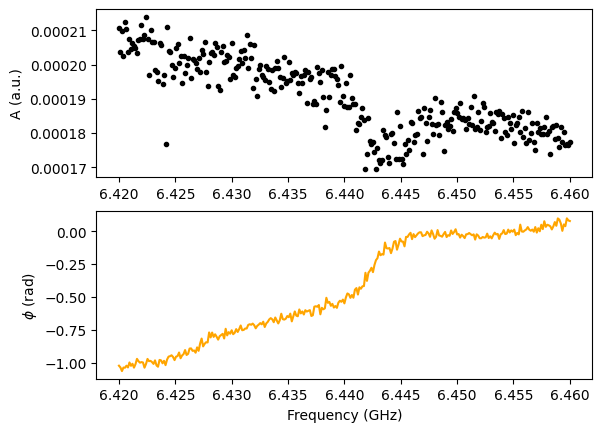

In [367]:
electrical_delay = 61e-9
# electrical_delay = 1
# _delay = 10e9

# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
# %matplotlib qt
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
# _phase = _delay*spec_freq*np.angle(spec_res)
# ax2.plot(spec_freq / 1e9, _phase, "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax2.axvline(6.4252/1e9)
# plt.axvline(6.447)

plt.show()

In [368]:
measure_q.parameters.readout_resonator_frequency = 6.447e9
measure_q.parameters.readout_range_out = -10
measure_q.parameters.readout_range_in = -15
measure_q.parameters.user_defined['readout_amp'] = 0.9
electrical_delay = 65.1e-9

device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.3.3 Apply Experiment Parameters and Compile

In [369]:
num_freq_points = num_points

In [370]:
amplitude_sweep = LinearSweepParameter(
    uid="amp_sweep_param", start=0.01, stop=0.99, count=num_amp_points
)

readout_pulse = create_readout_pulse(measure_q)
frequency_sweep = create_readout_freq_sweep(
    measure_q, start_freq, stop_freq, num_freq_points
)

exp_spec_amp = res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
)

exp_spec_amp.set_calibration(res_spec_calib(frequency_sweep, amplitude_sweep))
exp_spec_amp.set_signal_map(res_spec_map(measure_q))

In [371]:
# compile the experiment on the open instrument session
compiled_spec_amp = session.compile(exp_spec_amp)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet(
    "Pulse_Sheets/Spectroscopy_vs_Amplitude_Pulse_Sheet", compiled_spec_amp
)

[2024.07.11 15:10:34.511] INFO    Starting LabOne Q Compiler run...
[2024.07.11 15:10:34.571] INFO    Schedule completed. [0.056 s]
[2024.07.11 15:10:35.057] INFO    Code generation completed for all AWGs. [0.490 s]
[2024.07.11 15:10:35.067] INFO    Completed compilation step 1 of 11. [0.552 s]
[2024.07.11 15:10:35.067] INFO    Skipping compilation for next step(s)...
[2024.07.11 15:10:35.078] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:10:35.078] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.11 15:10:35.078] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:10:35.078] INFO      device_shfqc     0         21            0           1      8000  
[2024.07.11 15:10:35.087] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:10:35.092] INFO      TOTAL                      21            0                  8000  
[2024.07.11

Z:\projects\2024-fluxonium\measurement\coupler_20240702\LabOneQ\Pulse_Sheets\Spectroscopy_vs_Amplitude_Pulse_Sheet_2024-07-11-15-10-35.html

In [372]:
# run the compiled experiemnt
spec_amp_results = session.run(compiled_spec_amp)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_amp_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_amp_results_{timestamp}.json")

[2024.07.11 15:10:35.518] INFO    Configuring the device setup
[2024.07.11 15:10:35.635] INFO    The device setup is configured
[2024.07.11 15:10:36.704] INFO    Starting near-time execution...
[2024.07.11 15:10:44.788] INFO    Finished near-time execution.
File saved as Results_Needed/spec_amp_results_20240711T151044.json


#### plot results

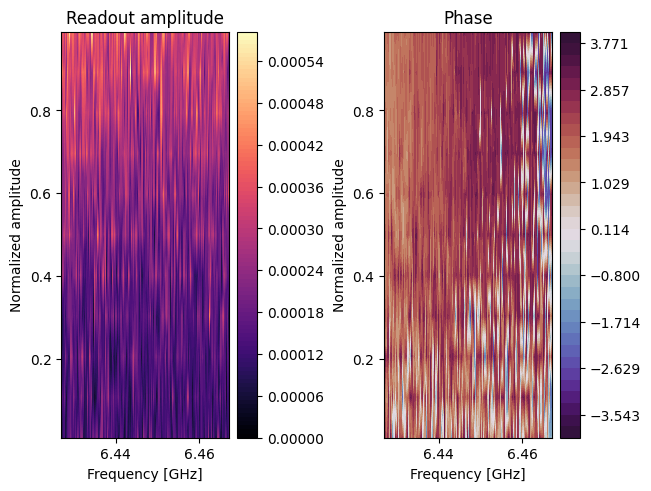

In [373]:
# plot the results
lo_freq = measure_q.parameters.readout_lo_frequency
spec_freq = lo_freq + spec_amp_results.get_axis("res_spec_pulsed")[1]
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

X, Y = np.meshgrid(spec_freq, amp)
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
CS = ax[0].contourf(X / 1e9, Y, np.abs(data), levels=100, cmap="magma")
ax[0].set_title("Readout amplitude")
ax[0].set_xlabel("Frequency [GHz]")
ax[0].set_ylabel("Normalized amplitude")
fig.colorbar(CS)

max_value = (
    max(
        # int(np.abs(np.min(np.unwrap(np.angle(data, deg=False))))),
        # int(np.abs(np.max(np.unwrap(np.angle(data, deg=False))))),
        int(np.abs(np.min(np.angle(data, deg=False)))),
        int(np.abs(np.max(np.angle(data, deg=False)))),
    )
    + 1
)

cs2_levels = np.linspace(-max_value, max_value, 4*(2 * (max_value) + 1))

CS2 = ax[1].contourf(
    X / 1e9,
    Y,
    # np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data)),
    np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data),
    levels=cs2_levels,
    cmap="twilight_shifted",
)
ax[1].set_title("Phase")
ax[1].set_xlabel("Frequency [GHz]")
ax[1].set_ylabel("Normalized amplitude")
fig.colorbar(CS2)

## Resonator vs flux 

### resonator spectroscopy setup

In [480]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -10e6
stop_freq = 15e6
num_points = 201

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

readout_pulse = create_readout_pulse(measure_q)

In [481]:
2**12

4096

In [482]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6822600000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.04,
│   │   │   'reset_length': 5e-06,
│   │   │   'readout_range_out': -30,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

In [483]:
# measure_q.parameters.user_defined['readout_amp'] = 0.1
# measure_q.parameters.readout_range_out = -30
# measure_q.parameters.readout_range_in = -15
# device_setup.set_calibration(
#     measure_q.calibration()
# )

#### 3.2.2 Experiment Definition

In [484]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [485]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [486]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [487]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.07.09 21:58:25.870] INFO    Starting LabOne Q Compiler run...
[2024.07.09 21:58:25.929] INFO    Schedule completed. [0.056 s]
[2024.07.09 21:58:26.134] INFO    Code generation completed for all AWGs. [0.199 s]
[2024.07.09 21:58:26.138] INFO    Completed compilation step 1 of 1. [0.264 s]
[2024.07.09 21:58:26.148] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.09 21:58:26.153] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.09 21:58:26.157] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.09 21:58:26.160] INFO      device_shfqc     0         23            0           1      8000  
[2024.07.09 21:58:26.162] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.09 21:58:26.165] INFO      TOTAL                      23            0                  8000  
[2024.07.09 21:58:26.169] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240702\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-07-09-21-58-26.html

#### 3.2.4 Run and Evaluate Experiment

In [488]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.07.09 21:58:26.593] INFO    Configuring the device setup
[2024.07.09 21:58:26.708] INFO    The device setup is configured
[2024.07.09 21:58:27.883] INFO    Starting near-time execution...
[2024.07.09 21:58:28.326] INFO    Estimated RT execution time: 9.88 s.
[2024.07.09 21:58:38.539] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240709T215838.json


In [489]:
# electrical_delay = 65.0e-9

Text(0.5, 0, 'Frequency (GHz)')

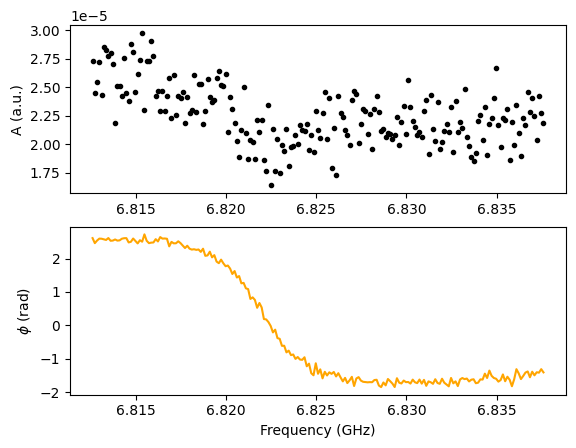

In [490]:
# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = (
    measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
)

if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_resonator_frequency * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax2.axvline(spec_freq[np.argmin(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res))]/1e9)
# spec_freq[np.argmin(abs(spec_res))]/1e9

In [491]:
measure_q?

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6822600000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-30,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.04,
│   │   │   'reset_length': 5e-06,
│   │   │   'readout_range_out': -30,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

Type:           Transmon
String form:    
File:           c:\users\qnlbe\.conda\envs\laboneq\lib\site-packages\laboneq\dsl\quantum\transmon.py
Docstring:      A class for a superconducting, flux-tuneable Transmon Qubit.
Init docstring:
Initializes a new Transmon Qubit.

Args:
    uid: A unique identifier for the Qubit.
    signals: A mapping of logical signals associated with the qubit.
        Qubit accepts the following keys in the mapping: 'drive', 'measure', 'acquire', 'flux'

        This is so that the Qubit parameters are assigned into the correct signal lines in
        calibration.
    parameters: Parameters associated with the qubit.
        Required for generating calibration and experiment signals via `calibration()` and `experiment_signals()`.

### f_r vs phi ext

In [22]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.05s


In [23]:
dc.ramp_current(0e-3, 1e-6,0)
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [317]:
dc.output('off')
dc.source_mode('CURR')

In [318]:
dc.output('on')
dc.ramp_current(0.1e-3, 0.5e-6,0)
dc.ramp_current(0.0e-3, 0.5e-6,0)

In [319]:
import sys

In [492]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(0.01)

start_curr = -6e-3
stop_curr = 6e-3
# stop_curr = 3e-3
current_sweep = np.linspace(start_curr,stop_curr, 1001)

dc.ramp_current(0e-3, 0.5e-6, 0)

dc.output('off')
dc.source_mode('CURR')

dc.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

dc.ramp_current(0,0.5e-6,0)
dc.output('off')

step 0
current: -0.006
[2024.07.09 22:00:59.599] INFO    Configuring the device setup
[2024.07.09 22:00:59.714] INFO    The device setup is configured
[2024.07.09 22:01:00.499] INFO    Starting near-time execution...
[2024.07.09 22:01:00.947] INFO    Estimated RT execution time: 9.88 s.
[2024.07.09 22:01:11.140] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240709T220111.json
step 1
current: -0.005988
[2024.07.09 22:01:12.260] INFO    Starting near-time execution...
[2024.07.09 22:01:12.748] INFO    Estimated RT execution time: 9.88 s.
[2024.07.09 22:01:22.851] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240709T220123.json
step 2
current: -0.005976
[2024.07.09 22:01:24.410] INFO    Starting near-time execution...
[2024.07.09 22:01:24.862] INFO    Estimated RT execution time: 9.88 s.
[2024.07.09 22:01:35.063] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240

Text(0.5, 1.0, 'LogMag [arb.]')

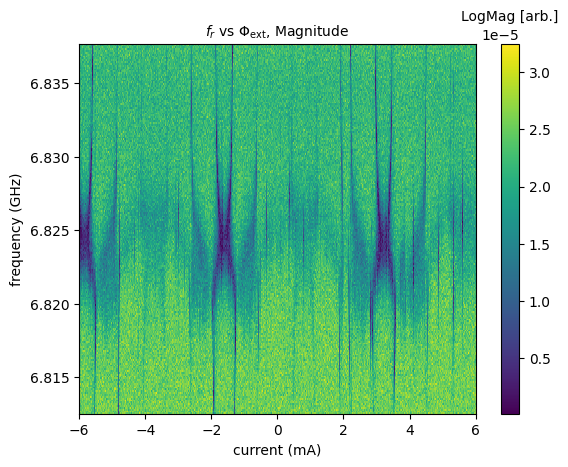

In [493]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

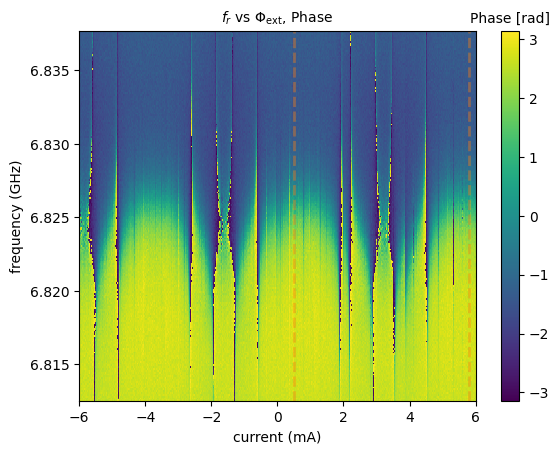

In [500]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

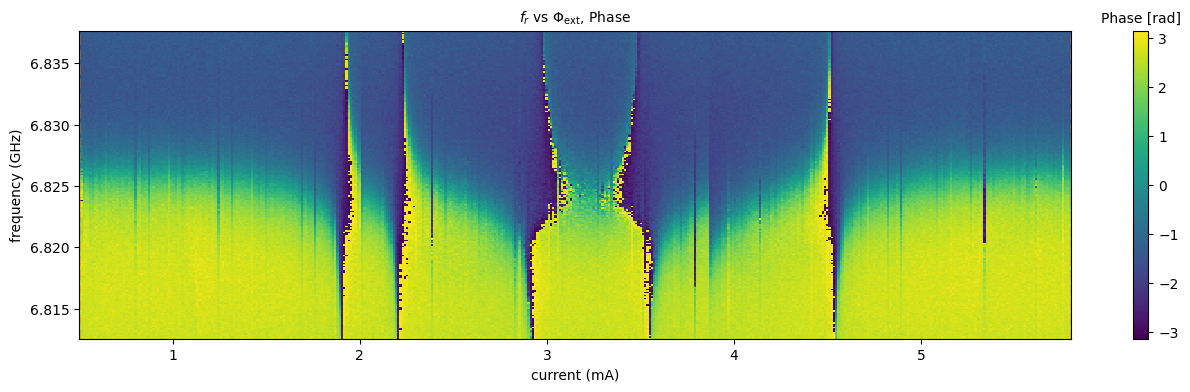

In [505]:
plt.figure(figsize=(16, 4))
plt.pcolor(current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.xlim(0.5, 5.8)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

In [514]:
electrical_delay = 65.001e-9

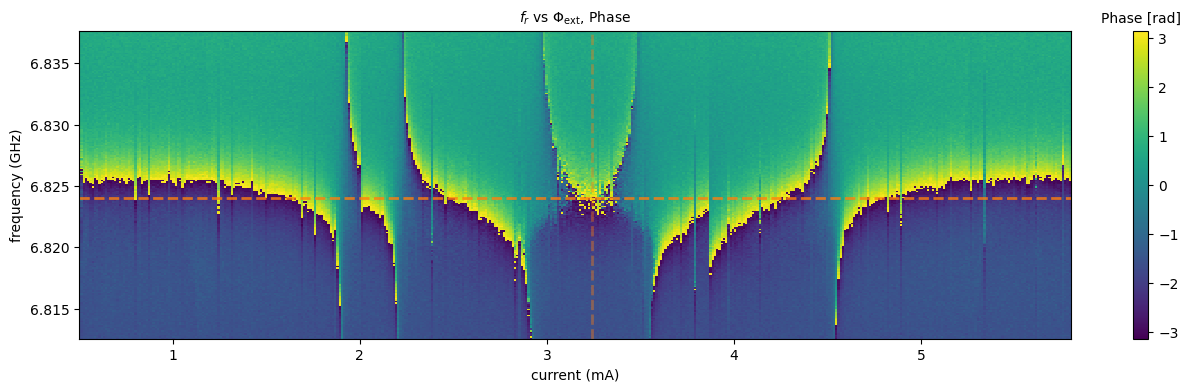

In [538]:
plt.figure(figsize=(16, 4))
plt.pcolor(current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.xlim(0.5, 5.8)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
# plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(3.24, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axhline(6.824, c='tab:orange', alpha=0.8, lw=2, ls='--')

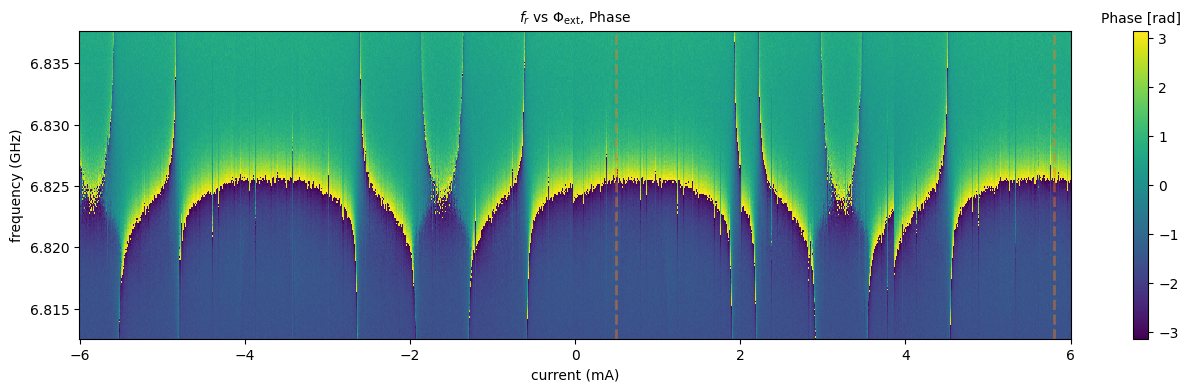

In [517]:
plt.figure(figsize=(16, 4))
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

In [523]:
np.shape(sweep_rspec_results)

(1001, 201)

In [528]:
plot_data = (np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results))

In [529]:
plot_data.shape

(1001, 201)

In [527]:
spec_freq.shape

(201,)

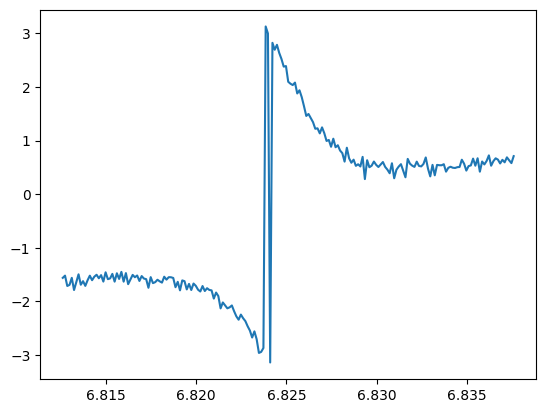

In [531]:
plt.plot(spec_freq/1e9, plot_data[500])

## Two tone (pulsed qubit spectroscopy)

### Setup current source

In [691]:
current_set_point = 3.24e-3
# current_set_point = 1e-3

In [ ]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

In [544]:
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [692]:
# turn on current and set to half flux value

dc.output('on')
dc.ramp_current(current_set_point, 0.5e-6, 0)

In [560]:
dc.ramp_current(0, 0.5e-6, 0)

#### 3.5.1 Additional Experimental Parameters

Define the frequency scan and the pulses used in the experiment

In [309]:
measure_q.parameters.readout_range_in = -10
measure_q.parameters.readout_range_out = -15
measure_q.parameters.user_defined['readout_amp'] = 0.9
measure_q.parameters.readout_resonator_frequency = 6.447e9


In [310]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
qspec_num = 2001

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

In [311]:
2**12

4096

In [312]:
# measure_q.parameters.resonance_frequency_ge = 1e9
# measure_q.parameters.resonance_frequency_ef = 1e9
# device_setup.set_calibration(measure_q.calibration())

In [313]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=6500000000.0,
│   │   resonance_frequency_ef=6500000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6447000000.0,
│   │   readout_lo_frequency=6100000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 1e-06
│   │   }
│   )
)

In [341]:
### QB spec
# q_freq = 5.35e9
drive_lo_freq = 6.5e9
measure_q.parameters.drive_lo_frequency = drive_lo_freq
measure_q.parameters.resonance_frequency_ge = drive_lo_freq
measure_q.parameters.resonance_frequency_ef = drive_lo_freq
LF_path = False
start_freq = -500e6
stop_freq = 500e6
measure_q.parameters.user_defined['amplitude_pi'] = 0.99
measure_q.parameters.user_defined['readout_amp'] = 0.9
measure_q.parameters.drive_range = 10
measure_q.parameters.user_defined['reset_length'] = 1e-6
measure_q.parameters.user_defined['pulse_length'] = 2000e-09
measure_q.parameters.readout_resonator_frequency = 6.449e9
# measure_q.parameters.readout_resonator_frequency = 6.825e9
measure_q.parameters.readout_lo_frequency = 6.1e9


print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=6500000000.0,
│   │   resonance_frequency_ef=6500000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6449000000.0,
│   │   readout_lo_frequency=6100000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 1e-06
│   │   }
│   )
)

In [342]:
res = ((stop_freq - start_freq)/qspec_num)*1e-6
print(f'Drive freq resolution = {res} MHz')

Drive freq resolution = 0.49975012493753124 MHz


In [343]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [344]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [345]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

In [346]:
freq_sweep_q.start/1e9

-0.5

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [347]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [348]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.07.11 14:56:07.445] INFO    Starting LabOne Q Compiler run...
[2024.07.11 14:56:08.172] INFO    Schedule completed. [0.724 s]
[2024.07.11 14:56:15.270] INFO    Code generation completed for all AWGs. [7.092 s]
[2024.07.11 14:56:15.274] INFO    Completed compilation step 1 of 1. [7.825 s]
[2024.07.11 14:56:15.285] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.11 14:56:15.288] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.11 14:56:15.290] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.11 14:56:15.292] INFO      device_shfqc        0         10            0           1      8000  
[2024.07.11 14:56:15.294] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.07.11 14:56:15.296] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.11 14:56:15.296] INFO      TOTAL                         32 

In [349]:
# # turn on current and set to half flux value

# dc.output('on')
# dc.ramp_current(current_set_point, 0.5e-6, 0)

In [350]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.07.11 14:56:15.316] INFO    Configuring the device setup
[2024.07.11 14:56:15.427] INFO    The device setup is configured
[2024.07.11 14:56:16.593] INFO    Starting near-time execution...
[2024.07.11 14:56:17.191] INFO    Estimated RT execution time: 41.70 s.
[2024.07.11 14:56:59.215] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240711T145659.json


Text(0.5, 0, 'Frequency (GHz)')

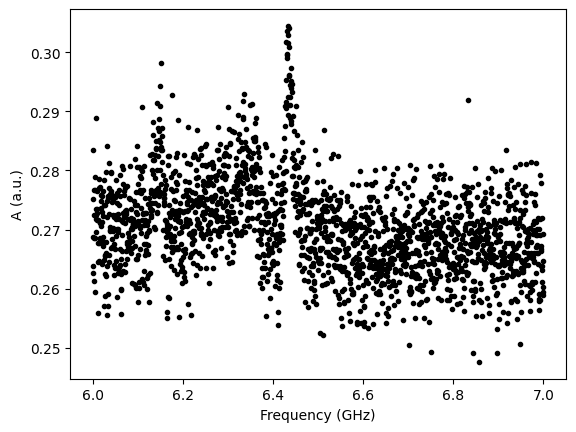

In [351]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

# plt.axvline(2.1545, linestyle = '--')
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
# print('estimated frequency ' + str(qspec_freq[np.argmin(abs(qspec_res))]/1e9) + ' GHz')

# Q1

In [10]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.04s


In [11]:
dc.ramp_current(0e-3, 1e-6,0)
dc.off()
dc.output('off')
dc.source_mode('CURR')
dc.ramp_current(0e-3, 1e-6,0)

In [317]:
dc.output('off')
dc.source_mode('CURR')

In [318]:
dc.output('on')
dc.ramp_current(0.1e-3, 0.5e-6,0)
dc.ramp_current(0.0e-3, 0.5e-6,0)

## set current

In [324]:
# dc.ramp_current(1e-3, 0.5e-6,0)
dc.output('on')
dc.ramp_current(0.17e-3, 0.5e-6,0)

In [306]:
dc.ramp_current(0e-3, 0.5e-6,1e-3)
dc.output('off')

In [460]:
measure_q.parameters.readout_resonator_frequency = 6.14e9
measure_q.parameters.readout_range_out = -20
measure_q.parameters.readout_range_in = -10
measure_q.parameters.user_defined['readout_amp'] = 0.8
electrical_delay = 65.0e-9

device_setup.set_calibration(
    measure_q.calibration()
)

In [461]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5500000000.0,
│   │   resonance_frequency_ef=5500000000.0,
│   │   drive_lo_frequency=5500000000.0,
│   │   readout_resonator_frequency=6140000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.8,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -10
│   │   }
│   )
)

## Resonator vs flux 

### resonator spectroscopy setup

In [508]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -2e6
stop_freq = 2e6
num_points = 121

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

readout_pulse = create_readout_pulse(measure_q)

In [509]:
2**12

4096

In [510]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5500000000.0,
│   │   resonance_frequency_ef=5500000000.0,
│   │   drive_lo_frequency=5500000000.0,
│   │   readout_resonator_frequency=6140000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-20,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.8,
│   │   │   'reset_length': 1e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -10
│   │   }
│   )
)

In [511]:
# measure_q.parameters.user_defined['readout_amp'] = 0.1
# measure_q.parameters.readout_range_out = -30
# measure_q.parameters.readout_range_in = -15
# device_setup.set_calibration(
#     measure_q.calibration()
# )

#### 3.2.2 Experiment Definition

In [512]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter

def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=10e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [513]:
# measure_q.parameters.readout_range_out = 5

# # apply calibration to device setup
device_setup.set_calibration(
    measure_q.calibration()
)

In [514]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [515]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.07.11 12:11:58.901] INFO    Starting LabOne Q Compiler run...
[2024.07.11 12:11:58.933] INFO    Schedule completed. [0.028 s]
[2024.07.11 12:11:59.006] INFO    Code generation completed for all AWGs. [0.070 s]
[2024.07.11 12:11:59.008] INFO    Completed compilation step 1 of 1. [0.103 s]
[2024.07.11 12:11:59.014] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 12:11:59.016] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.11 12:11:59.018] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 12:11:59.020] INFO      device_shfqc     0         23            0           1      8000  
[2024.07.11 12:11:59.022] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 12:11:59.024] INFO      TOTAL                      23            0                  8000  
[2024.07.11 12:11:59.025] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-fluxonium\measurement\coupler_20240702\LabOneQ\Pulse_Sheets\Pulsed_Spectroscopy_2024-07-11-12-11-59.html

#### 3.2.4 Run and Evaluate Experiment

In [516]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.07.11 12:11:59.176] INFO    Configuring the device setup
[2024.07.11 12:11:59.285] INFO    The device setup is configured
[2024.07.11 12:12:00.492] INFO    Starting near-time execution...
[2024.07.11 12:12:00.927] INFO    Estimated RT execution time: 5.95 s.
[2024.07.11 12:12:07.118] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240711T121207.json


In [517]:
electrical_delay = 66.3e-9

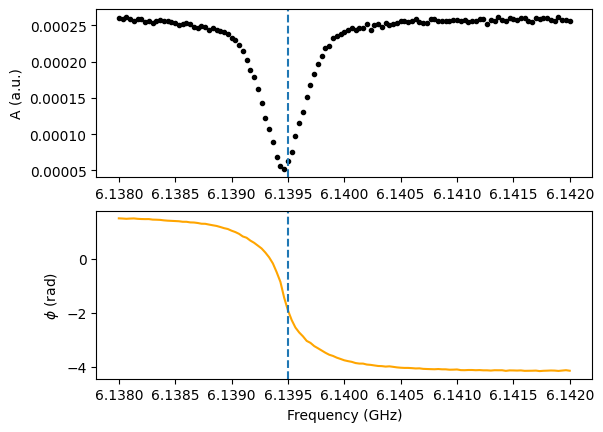

In [518]:
# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = (
    measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
)

if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_resonator_frequency * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
# ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
ax2.plot(spec_freq / 1e9, np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res)), "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax2.axvline(spec_freq[np.argmin(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res))]/1e9)
# spec_freq[np.argmin(abs(spec_res))]/1e9

test_f = 6.1395
ax1.axvline(test_f, ls='--')
ax2.axvline(test_f, ls='--')

### f_r vs phi ext

In [ ]:
plot = False  # plot individual resonator spectroscopy
dc.current_range(0.01)

start_curr = -6e-3
stop_curr = 6e-3
# stop_curr = 3e-3
current_sweep = np.linspace(start_curr,stop_curr, 1001)

dc.ramp_current(0e-3, 0.5e-6, 0)

dc.output('off')
dc.source_mode('CURR')

dc.output('on')
sweep_rspec_results = []
for i, current in enumerate(current_sweep):
    print('step ' + str(i))
    print(f'current: {current}')
    
    dc.ramp_current(current, 0.5e-6, 0)

    # debugging
    # dc.ramp_current(0e-3, 1e-6,0)
    # dc.output('off')
    # sys.exit()
    # time.sleep(0.5)
    
    # run the experiment on qubit 0
    rspec_results = session.run()

    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
    print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")
    
    # get the measurement data returned by the instruments from the QCCS session
    spec_res = rspec_results.get_data("res_spec_pulsed")
    # define the frequency axis from the qubit parameters
    spec_freq = (
        measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
    )
    sweep_rspec_results.append(spec_res)

    # plot the measurement data
    if plot:
        plt.figure()
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
        ax2.plot(spec_freq / 1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*spec_res), "orange")
        ax1.set_ylabel("A (a.u.)")
        ax2.set_ylabel("$\\phi$ (rad)")
        ax2.set_xlabel("Frequency (GHz)")
        ax2.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)

dc.ramp_current(0,0.5e-6,0)
dc.output('off')

In [ ]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Magnitude', size=10)
plt.colorbar().ax.set_title('LogMag [arb.]', size=10)

In [ ]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

In [ ]:
plt.figure(figsize=(16, 4))
plt.pcolor(current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.xlim(0.5, 5.8)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

In [ ]:
electrical_delay = 65.001e-9

In [ ]:
plt.figure(figsize=(16, 4))
plt.pcolor(current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.xlim(0.5, 5.8)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
# plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(3.24, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axhline(6.824, c='tab:orange', alpha=0.8, lw=2, ls='--')

In [ ]:
plt.figure(figsize=(16, 4))
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.title('phase')
plt.title(r'$f_r$ vs $\Phi_{\text{ext}}$, Phase', size=10)
plt.colorbar().ax.set_title('Phase [rad]', size=10)
plt.axvline(0.5, c='tab:orange', alpha=0.4, lw=2, ls='--')
plt.axvline(5.8, c='tab:orange', alpha=0.4, lw=2, ls='--')
# plt.axhline(6.6624, c='tab:purple', alpha=0.4)

In [ ]:
np.shape(sweep_rspec_results)

In [ ]:
plot_data = (np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*sweep_rspec_results))

In [ ]:
plot_data.shape

In [ ]:
spec_freq.shape

In [ ]:
plt.plot(spec_freq/1e9, plot_data[500])

## Two tone (pulsed qubit spectroscopy)

### Setup current source

In [280]:
current_set_point = 0.17e-3

In [281]:
# dc.output('on')
dc.ramp_current(current_set_point, 0.5e-6, 0)

#### 3.5.1 Additional Experimental Parameters

Define the frequency scan and the pulses used in the experiment

In [383]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
# qspec_range = 500e6
# how many frequency points to measure
# qspec_num = 20001
qspec_num = 3001

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

In [342]:
2**13

8192

In [369]:
# measure_q.parameters.user_defined['readout_amp'] = 0.2
# measure_q.parameters.readout_range_out = -20
# measure_q.parameters.readout_range_in = -10
# device_setup.set_calibration(
#     measure_q.calibration()
# )

In [239]:
### QB spec
drive_lo_freq = 3.5e9
# drive_lo_freq = 2.4e9
measure_q.parameters.drive_lo_frequency = drive_lo_freq
measure_q.parameters.resonance_frequency_ge = drive_lo_freq
measure_q.parameters.resonance_frequency_ef = drive_lo_freq
LF_path = False
# start_freq = -250e6
# stop_freq = -190e6
start_freq = -500e6
stop_freq = 500e6
measure_q.parameters.user_defined['amplitude_pi'] = 0.99

measure_q.parameters.drive_range = 10
measure_q.parameters.user_defined['reset_length'] = 1e-6
measure_q.parameters.user_defined['pulse_length'] = 2000e-09
# measure_q.parameters.readout_resonator_frequency = 6.426e9
measure_q.parameters.readout_resonator_frequency = 6.447

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3500000000.0,
│   │   resonance_frequency_ef=3500000000.0,
│   │   drive_lo_frequency=3500000000.0,
│   │   readout_resonator_frequency=6.447,
│   │   readout_lo_frequency=6100000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 1e-06
│   │   }
│   )
)

In [240]:
res = ((stop_freq - start_freq)/qspec_num)*1e-6
print(f'Drive freq resolution = {res} MHz')

Drive freq resolution = 0.49975012493753124 MHz


In [241]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [242]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter


def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [243]:
freq_sweep_q = create_drive_freq_sweep(measure_q, start_freq, stop_freq, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()

if LF_path == True:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
        port_mode = PortMode.LF
    )
else:
    exp_calibration_q["drive"] = SignalCalibration(
        oscillator=Oscillator(
            frequency=freq_sweep_q,
            modulation_type=ModulationType.HARDWARE,
        ),
    )

In [244]:
freq_sweep_q.start/1e9

-0.5

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [245]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [246]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

#Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
#show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)

# plot_simulation(compiled_qspec, 0, 10e-6)

[2024.07.11 14:38:30.660] INFO    Starting LabOne Q Compiler run...
[2024.07.11 14:38:31.411] INFO    Schedule completed. [0.748 s]
[2024.07.11 14:38:38.142] INFO    Code generation completed for all AWGs. [6.726 s]
[2024.07.11 14:38:38.145] INFO    Completed compilation step 1 of 1. [7.481 s]
[2024.07.11 14:38:38.153] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.11 14:38:38.156] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.11 14:38:38.159] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.11 14:38:38.162] INFO      device_shfqc        0         10            0           1      8000  
[2024.07.11 14:38:38.164] INFO      device_shfqc_sg     0         22            1           1      8000  
[2024.07.11 14:38:38.166] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.07.11 14:38:38.169] INFO      TOTAL                         32 

In [247]:
# # turn on current and set to half flux value

# dc.output('on')
# dc.ramp_current(current_set_point, 0.5e-6, 0)

In [248]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.07.11 14:38:38.235] INFO    Configuring the device setup
[2024.07.11 14:38:38.346] INFO    The device setup is configured
[2024.07.11 14:38:39.689] INFO    Starting near-time execution...
[2024.07.11 14:38:40.695] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240711T143840.json


Text(0.5, 0, 'Frequency (GHz)')

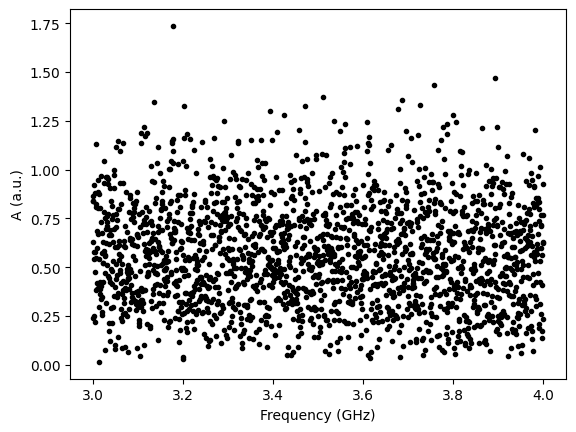

In [249]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

if emulate:
    # create some dummy data if running in emulation mode
    qspec_res = lorentzian(
        qspec_freq,
        5e6,
        measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

# plt.axvline(4.41, linestyle = '--', alpha=0.5)
# plt.axvline(qspec_freq[np.argmin(abs(qspec_res))]/1e9 , linestyle = '--')
# print('estimated frequency ' + str(qspec_freq[np.argmin(abs(qspec_res))]/1e9) + ' GHz')

### 3.3 Resonator Spectroscopy v/ Power
* _It is possible to define the spectroscopy experiments in a more general way, so that CW and pulsed spectroscopy can be chosen with an argument to the function. However, this is not done here for the sake of clarity. Pulsed measurements are used to more closely match final readout pulse_
#### 3.3.1 Additional experimental parameters

In [374]:
# frequency range of spectroscopy scan -
# around expected centre frequency as defined in qubit parameters
start_freq = -50e6
stop_freq = 50e6
num_freq_points = 1001

# set number of points for amplitude sweep
num_amp_points = 11

In [375]:
num_averages = 11

In [376]:
measure_q.parameters.readout_resonator_frequency = 6.449e9

In [385]:
measure_q.parameters.readout_range_out = -15
measure_q.parameters.readout_range_in = -10
device_setup.set_calibration(measure_q.calibration())
# measure_q.parameters.user_defined['readout_amp'] = 0.2
# measure_q.parameters.drive_lo_frequency = 6.0e9

device_setup.set_calibration(
    measure_q.calibration()
)

In [386]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [387]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=6500000000.0,
│   │   resonance_frequency_ef=6500000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6449000000.0,
│   │   readout_lo_frequency=6100000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 1e-06
│   │   }
│   )
)

#### 3.3.2 Experiment Definition

In [388]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep and amplitude sweeps as parameters


def res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive amplitude
    with exp_spec.sweep(uid="res_amp", parameter=amplitude_sweep):
        with exp_spec.acquire_loop_rt(
            uid="shots",
            count=2**num_averages,
            acquisition_type=AcquisitionType.SPECTROSCOPY,
        ):
            #inner loop - sweep frequency
            with exp_spec.sweep(uid="res_freq", parameter=frequency_sweep):
                # readout pulse and data acquisition
                with exp_spec.section(uid="spectroscopy"):
                    # play resonator excitation pulse
                    exp_spec.play(signal="measure", pulse=readout_pulse)
                    # resonator signal readout
                    exp_spec.acquire(
                        signal="acquire",
                        handle="res_spec_pulsed",
                        length=readout_pulse.length,
                    )
                with exp_spec.section(uid="delay"):
                    # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                    exp_spec.delay(signal="measure", time=1e-6)

    return exp_spec

#### 3.3.3 Apply Experiment Parameters and Compile

In [389]:
amplitude_sweep = LinearSweepParameter(
    uid="amp_sweep_param", start=0.01, stop=0.99, count=num_amp_points
)

readout_pulse = create_readout_pulse(measure_q)
frequency_sweep = create_readout_freq_sweep(
    measure_q, start_freq, stop_freq, num_freq_points
)

exp_spec_amp = res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
)

exp_spec_amp.set_calibration(res_spec_calib(frequency_sweep, amplitude_sweep))
exp_spec_amp.set_signal_map(res_spec_map(measure_q))

In [390]:
# compile the experiment on the open instrument session
compiled_spec_amp = session.compile(exp_spec_amp)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet(
    "Pulse_Sheets/Spectroscopy_vs_Amplitude_Pulse_Sheet", compiled_spec_amp
)

[2024.07.11 15:14:30.943] INFO    Starting LabOne Q Compiler run...
[2024.07.11 15:14:31.141] INFO    Schedule completed. [0.195 s]
[2024.07.11 15:14:32.517] INFO    Code generation completed for all AWGs. [1.373 s]
[2024.07.11 15:14:32.522] INFO    Completed compilation step 1 of 11. [1.576 s]
[2024.07.11 15:14:32.526] INFO    Skipping compilation for next step(s)...
[2024.07.11 15:14:32.537] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:14:32.541] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.11 15:14:32.544] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:14:32.547] INFO      device_shfqc     0         21            0           1      8000  
[2024.07.11 15:14:32.550] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:14:32.553] INFO      TOTAL                      21            0                  8000  
[2024.07.11

Z:\projects\2024-fluxonium\measurement\coupler_20240702\LabOneQ\Pulse_Sheets\Spectroscopy_vs_Amplitude_Pulse_Sheet_2024-07-11-15-14-32.html

In [391]:
# run the compiled experiemnt
spec_amp_results = session.run(compiled_spec_amp)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_amp_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_amp_results_{timestamp}.json")

[2024.07.11 15:14:34.486] INFO    Configuring the device setup
[2024.07.11 15:14:34.603] INFO    The device setup is configured
[2024.07.11 15:14:35.913] INFO    Starting near-time execution...
[2024.07.11 15:14:36.369] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:14:43.444] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:14:50.521] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:14:57.602] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:04.659] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:11.748] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:18.773] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:25.833] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:32.921] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:39.936] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:47.018] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:53.576]

#### 3.3.4 Run and Evaluate Experiment

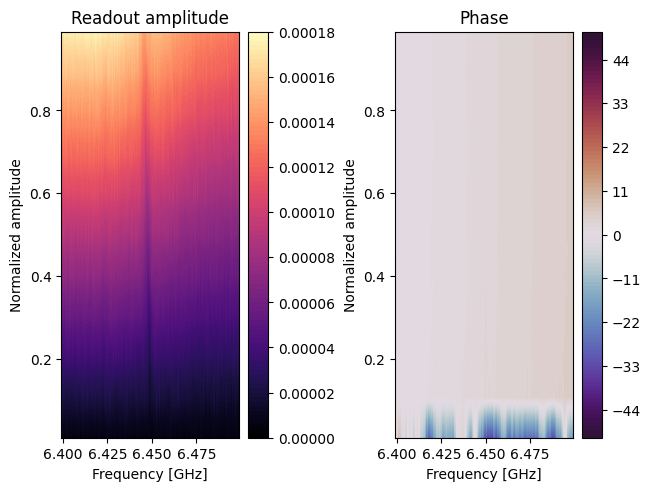

In [392]:
# plot the results
lo_freq = measure_q.parameters.readout_lo_frequency
spec_freq = lo_freq + spec_amp_results.get_axis("res_spec_pulsed")[1]
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

X, Y = np.meshgrid(spec_freq, amp)
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
CS = ax[0].contourf(X / 1e9, Y, np.abs(data), levels=100, cmap="magma")
ax[0].set_title("Readout amplitude")
ax[0].set_xlabel("Frequency [GHz]")
ax[0].set_ylabel("Normalized amplitude")
fig.colorbar(CS)

max_value = (
    max(
        int(np.abs(np.min(np.unwrap(np.angle(data, deg=False))))),
        int(np.abs(np.max(np.unwrap(np.angle(data, deg=False))))),
    )
    + 1
)

cs2_levels = np.linspace(-max_value, max_value, 2 * (max_value) + 1)

CS2 = ax[1].contourf(
    X / 1e9,
    Y,
    np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data)),
    levels=cs2_levels,
    cmap="twilight_shifted",
)
ax[1].set_title("Phase")
ax[1].set_xlabel("Frequency [GHz]")
ax[1].set_ylabel("Normalized amplitude")
fig.colorbar(CS2)

In [374]:
# frequency range of spectroscopy scan -
# around expected centre frequency as defined in qubit parameters
start_freq = -50e6
stop_freq = 50e6
num_freq_points = 1001

# set number of points for amplitude sweep
num_amp_points = 11

In [375]:
num_averages = 11

In [376]:
measure_q.parameters.readout_resonator_frequency = 6.449e9

In [385]:
measure_q.parameters.readout_range_out = -15
measure_q.parameters.readout_range_in = -10
device_setup.set_calibration(measure_q.calibration())
# measure_q.parameters.user_defined['readout_amp'] = 0.2
# measure_q.parameters.drive_lo_frequency = 6.0e9

device_setup.set_calibration(
    measure_q.calibration()
)

In [386]:
device_setup.set_calibration(
    measure_q.calibration()
)

In [387]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=6500000000.0,
│   │   resonance_frequency_ef=6500000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6449000000.0,
│   │   readout_lo_frequency=6100000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=-15,
│   │   readout_range_in=-10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 1e-06
│   │   }
│   )
)

#### 3.3.2 Experiment Definition

In [388]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep and amplitude sweeps as parameters


def res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive amplitude
    with exp_spec.sweep(uid="res_amp", parameter=amplitude_sweep):
        with exp_spec.acquire_loop_rt(
            uid="shots",
            count=2**num_averages,
            acquisition_type=AcquisitionType.SPECTROSCOPY,
        ):
            #inner loop - sweep frequency
            with exp_spec.sweep(uid="res_freq", parameter=frequency_sweep):
                # readout pulse and data acquisition
                with exp_spec.section(uid="spectroscopy"):
                    # play resonator excitation pulse
                    exp_spec.play(signal="measure", pulse=readout_pulse)
                    # resonator signal readout
                    exp_spec.acquire(
                        signal="acquire",
                        handle="res_spec_pulsed",
                        length=readout_pulse.length,
                    )
                with exp_spec.section(uid="delay"):
                    # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                    exp_spec.delay(signal="measure", time=1e-6)

    return exp_spec

#### 3.3.3 Apply Experiment Parameters and Compile

In [389]:
amplitude_sweep = LinearSweepParameter(
    uid="amp_sweep_param", start=0.01, stop=0.99, count=num_amp_points
)

readout_pulse = create_readout_pulse(measure_q)
frequency_sweep = create_readout_freq_sweep(
    measure_q, start_freq, stop_freq, num_freq_points
)

exp_spec_amp = res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
)

exp_spec_amp.set_calibration(res_spec_calib(frequency_sweep, amplitude_sweep))
exp_spec_amp.set_signal_map(res_spec_map(measure_q))

In [390]:
# compile the experiment on the open instrument session
compiled_spec_amp = session.compile(exp_spec_amp)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet(
    "Pulse_Sheets/Spectroscopy_vs_Amplitude_Pulse_Sheet", compiled_spec_amp
)

[2024.07.11 15:14:30.943] INFO    Starting LabOne Q Compiler run...
[2024.07.11 15:14:31.141] INFO    Schedule completed. [0.195 s]
[2024.07.11 15:14:32.517] INFO    Code generation completed for all AWGs. [1.373 s]
[2024.07.11 15:14:32.522] INFO    Completed compilation step 1 of 11. [1.576 s]
[2024.07.11 15:14:32.526] INFO    Skipping compilation for next step(s)...
[2024.07.11 15:14:32.537] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:14:32.541] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.07.11 15:14:32.544] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:14:32.547] INFO      device_shfqc     0         21            0           1      8000  
[2024.07.11 15:14:32.550] INFO     ────────────────────────────────────────────────────────────────── 
[2024.07.11 15:14:32.553] INFO      TOTAL                      21            0                  8000  
[2024.07.11

Z:\projects\2024-fluxonium\measurement\coupler_20240702\LabOneQ\Pulse_Sheets\Spectroscopy_vs_Amplitude_Pulse_Sheet_2024-07-11-15-14-32.html

In [391]:
# run the compiled experiemnt
spec_amp_results = session.run(compiled_spec_amp)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_amp_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_amp_results_{timestamp}.json")

[2024.07.11 15:14:34.486] INFO    Configuring the device setup
[2024.07.11 15:14:34.603] INFO    The device setup is configured
[2024.07.11 15:14:35.913] INFO    Starting near-time execution...
[2024.07.11 15:14:36.369] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:14:43.444] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:14:50.521] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:14:57.602] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:04.659] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:11.748] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:18.773] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:25.833] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:32.921] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:39.936] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:47.018] INFO    Estimated RT execution time: 6.33 s.
[2024.07.11 15:15:53.576]

#### 3.3.4 Run and Evaluate Experiment

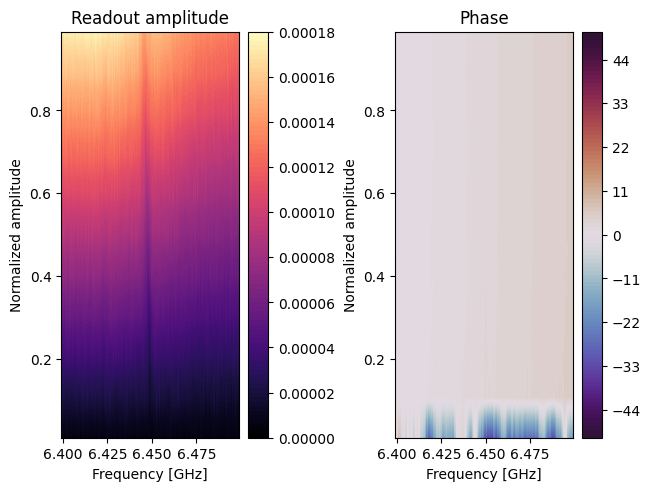

In [392]:
# plot the results
lo_freq = measure_q.parameters.readout_lo_frequency
spec_freq = lo_freq + spec_amp_results.get_axis("res_spec_pulsed")[1]
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

X, Y = np.meshgrid(spec_freq, amp)
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
CS = ax[0].contourf(X / 1e9, Y, np.abs(data), levels=100, cmap="magma")
ax[0].set_title("Readout amplitude")
ax[0].set_xlabel("Frequency [GHz]")
ax[0].set_ylabel("Normalized amplitude")
fig.colorbar(CS)

max_value = (
    max(
        int(np.abs(np.min(np.unwrap(np.angle(data, deg=False))))),
        int(np.abs(np.max(np.unwrap(np.angle(data, deg=False))))),
    )
    + 1
)

cs2_levels = np.linspace(-max_value, max_value, 2 * (max_value) + 1)

CS2 = ax[1].contourf(
    X / 1e9,
    Y,
    np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data)),
    levels=cs2_levels,
    cmap="twilight_shifted",
)
ax[1].set_title("Phase")
ax[1].set_xlabel("Frequency [GHz]")
ax[1].set_ylabel("Normalized amplitude")
fig.colorbar(CS2)

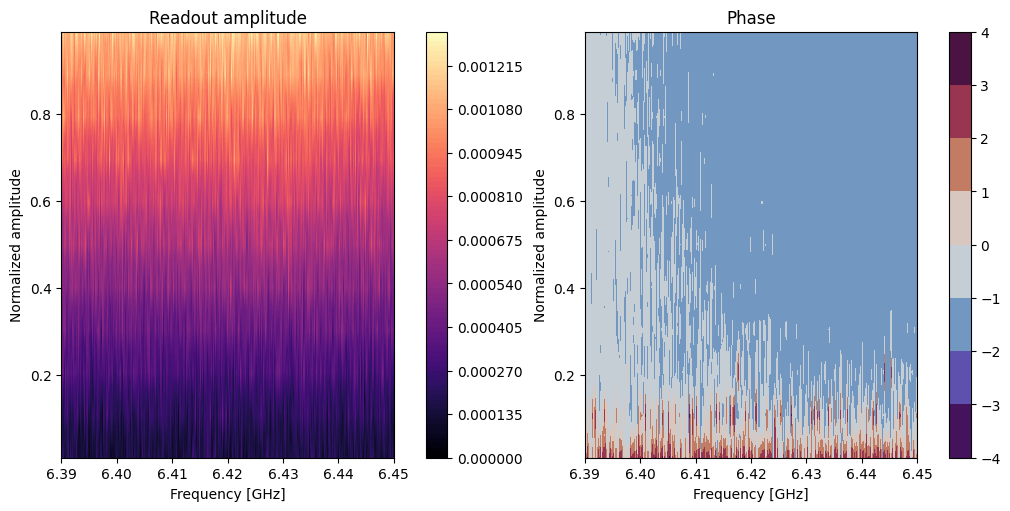

In [704]:
# plot the results
lo_freq = measure_q.parameters.readout_lo_frequency
spec_freq = lo_freq + spec_amp_results.get_axis("res_spec_pulsed")[1]
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

X, Y = np.meshgrid(spec_freq, amp)
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 5))
CS = ax[0].contourf(X / 1e9, Y, np.abs(data), levels=100, cmap="magma")
ax[0].set_title("Readout amplitude")
ax[0].set_xlabel("Frequency [GHz]")
ax[0].set_ylabel("Normalized amplitude")
fig.colorbar(CS)

max_value = (
    max(
        # int(np.abs(np.min(np.unwrap(np.angle(data, deg=False))))),
        # int(np.abs(np.max(np.unwrap(np.angle(data, deg=False))))),
        int(np.abs(np.min(np.angle(data, deg=False)))),
        int(np.abs(np.max(np.angle(data, deg=False)))),
    )
    + 1
)

cs2_levels = np.linspace(-max_value, max_value, 2 * (max_value) + 1)

CS2 = ax[1].contourf(
    X / 1e9,
    Y,
    # np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data)),
    np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data),
    levels=cs2_levels,
    cmap="twilight_shifted",
)
ax[1].set_title("Phase")
ax[1].set_xlabel("Frequency [GHz]")
ax[1].set_ylabel("Normalized amplitude")
fig.colorbar(CS2)

# ax[0].set_xlim((6.44, 6.455))
# ax[1].set_xlim((6.44, 6.455))

Text(0.5, 0, 'Frequency [GHz]')

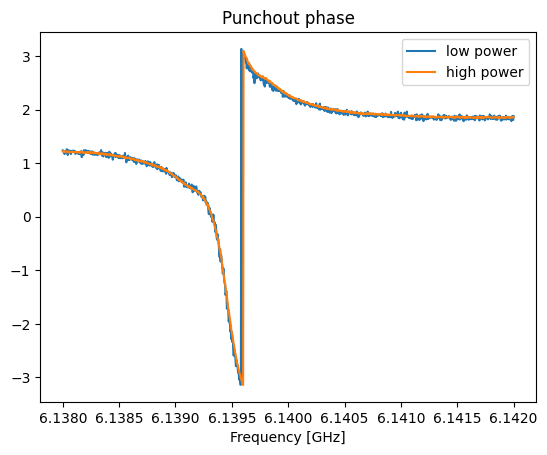

In [560]:
plt.plot(spec_freq*1e-9, 
         # np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data[2])),
         np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data[2]),
         # np.angle(data[2]), 
         label='low power')
plt.plot(spec_freq*1e-9, 
         # np.unwrap(np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data[-1])),
         np.angle(np.exp(1j*electrical_delay*2*np.pi*spec_freq)*data[-1]),
         # np.angle(data[-1]), 
         label='high power')
plt.legend()
plt.title('Punchout phase')
plt.xlabel('Frequency [GHz]')

# plt.xlim(6.44, 6.46)

Text(0.5, 0, 'Frequency [GHz]')

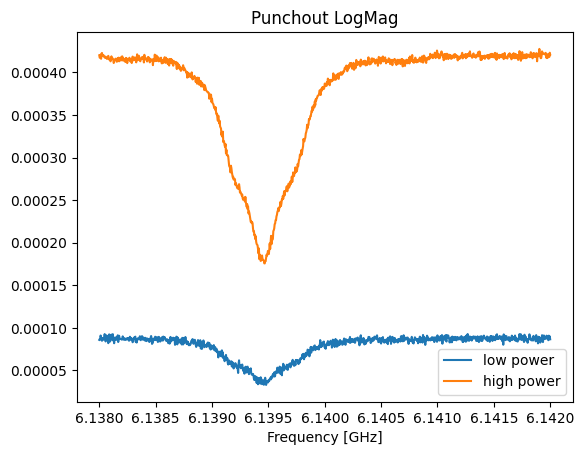

In [561]:
plt.plot(spec_freq*1e-9, abs(data[2]), label='low power')
plt.plot(spec_freq*1e-9, abs(data[-1]), label='high power')

plt.legend()
plt.title('Punchout LogMag')
plt.xlabel('Frequency [GHz]')

# plt.xlim(6.44, 6.46)

In [302]:
measure_q.parameters.user_defined['readout_range_out'] = -20
measure_q.parameters.user_defined['readout_range_in'] = -10
measure_q.parameters.user_defined['readout_amp'] = 0.1
device_setup.set_calibration(measure_q.calibration())
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6500000000.0,
│   │   readout_resonator_frequency=6040000000.0,
│   │   readout_lo_frequency=6500000000.0,
│   │   readout_integration_delay=6e-08,
│   │   drive_range=10,
│   │   readout_range_out=0,
│   │   readout_range_in=-15,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.99,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.1,
│   │   │   'reset_length': 5e-06,
│   │   │   'readout_range_out': -20,
│   │   │   'readout_range_in': -10
│   │   }
│   )
)